In [1]:
import numpy as np
from glob import glob
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seawater as sw
from scipy.interpolate import griddata
import matplotlib.patheffects as PathEffects
from matplotlib.path import Path
import matplotlib.gridspec as gridspec
from scipy.ndimage.filters import gaussian_filter as gfilter
from numpy.linalg import *
import pickle as pkl
import gc
import sys
import scipy.signal as sg
import xarray as xr
import dask.array as dsar

In [2]:
from collections import OrderedDict
# from romslab import zlevs
from glob import glob
from netCDF4 import Dataset
from datetime import datetime

import multiprocessing as mp

#from zlevs.py
def csf(sc, theta_s,theta_b):
#######################################################################
#
#  function h = csf(sc, theta_s,theta_b);
#
#  Further Information:
#  http://www.brest.ird.fr/Roms_tools/
#
#  This file is part of ROMSTOOLS
#
#  ROMSTOOLS is free software; you can redistribute it and/or modify
#  it under the terms of the GNU General Public License as published
#  by the Free Software Foundation; either version 2 of the License,
#  or (at your option) any later version.
#
#  ROMSTOOLS is distributed in the hope that it will be useful, but
#  WITHOUT ANY WARRANTY; without even the implied warranty of
#  MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#  GNU General Public License for more details.
#
#  You should have received a copy of the GNU General Public License
#  along with this program; if not, write to the Free Software
#  Foundation, Inc., 59 Temple Place, Suite 330, Boston,
#  MA  02111-1307  USA
#
######################################################################

    if (theta_s > 0 ):
        csrf=(1-np.cosh(sc*theta_s))/(np.cosh(theta_s)-1)
    else:
        csrf=-sc**2

    if (theta_b > 0):
        h = (np.exp(theta_b*csrf)-1)/(1-np.exp(-theta_b))
    else:
        h  = csrf.copy();

    return h


def zlevs(h,zeta,theta_s,theta_b,hc,N,type='w',vtransform=2):
    """
    ################################################################
    #
    #  function z = zlevs(h,zeta,theta_s,theta_b,hc,N,type);
    #
    #  this function compute the depth of rho or w points for ROMS
    #
    #  On Input:
    #
    #    type    'r': rho point 'w': w point
    #
    #  On Output:
    #
    #    z       Depths (m) of RHO- or W-points (3D matrix).
    #
    #  Further Information:
    #  http://www.brest.ird.fr/Roms_tools/
    #
    #  This file is part of ROMSTOOLS
    #
    #  ROMSTOOLS is free software; you can redistribute it and/or modify
    #  it under the terms of the GNU General Public License as published
    #  by the Free Software Foundation; either version 2 of the License,
    #  or (at your option) any later version.
    #
    #  ROMSTOOLS is distributed in the hope that it will be useful, but
    #  WITHOUT ANY WARRANTY; without even the implied warranty of
    #  MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    #  GNU General Public License for more details.
    #
    #  You should have received a copy of the GNU General Public License
    #  along with this program; if not, write to the Free Software
    #  Foundation, Inc., 59 Temple Place, Suite 330, Boston,
    #  MA  02111-1307  USA
    #
    #  Copyright (c) 2002-2006 by Pierrick Penven
    #  e-mail:Pierrick.Penven@ird.fr
    #  Translated to Python by Rafael Soutelino, rsoutelino@gmail.com
    #  Last Modification: Aug, 2010
    ################################################################
    """

    M, L = h.shape

    # Set S-Curves in domain [-1 < sc < 0] at vertical W- and RHO-points.

    sc_r=np.zeros(N)
    Cs_r=np.zeros(N)
    sc_w=np.zeros(N+1)
    Cs_w=np.zeros(N+1)

    if (vtransform == 2):
        ds=1./N;
        if type=='w':

            sc_w[0] = -1.0
            sc_w[-1] =  0
            Cs_w[0] = -1.0
            Cs_w[-1] =  0

            sc_w[1:N] = ds*(np.arange(1,N)-N)
            Cs_w = csf(sc_w, theta_s,theta_b)
            N+=1
    #    Still in matlab code
    #    disp(['===================================='])
    #    for k=N:-1:1
    #        disp(['Niveau S=',num2str(k),' Cs=',num2str( Cs_w(k), '%8.7f')])
    #    end
    #    disp(['===================================='])

        else:

            sc = ds*(np.arange(1,N+1)-N-0.5)
            Cs_r = csf(sc, theta_s,theta_b)
            sc_r = sc.copy()
    #    Still in matlab code
    #    disp(['===================================='])
    #    for k=N:-1:1
    #        disp(['Niveau S=',num2str(k),' Cs=',num2str( Cs_r(k), '%8.7f')])
    #    end
    #    disp(['===================================='])

    else:
        cff1 = 1.0 / np.sinh( theta_s )
        cff2 = 0.5 / np.tanh( 0.5*theta_s )
        ##
        if type=='w':
            sc = ( np.arange(0,N+1) - N ) / N
            N  = N + 1
        else:
            sc = ( np.arange(1,N+1) - N - 0.5 ) / N
        ##

        Cs = (1 - theta_b) * cff1 * np.sinh( theta_s * sc ) + \
            theta_b * ( cff2 * np.tanh(theta_s *(sc + 0.5) ) - 0.5 )

    #   Still in matlab code
    #    disp(['===================================='])
    #    for k=N:-1:1
    #        disp(['Niveau S=',num2str(k),' Cs=',num2str( Cs(k), '%8.7f')])
    #    end
    #    disp(['===================================='])

    # ------------------------------------------------------------------ #

    # Create S-coordinate system: based on model topography h(i,j),
    # fast-time-averaged free-surface field and vertical coordinate
    # transformation metrics compute evolving depths of of the three-
    # dimensional model grid. Also adjust zeta for dry cells.

    Dcrit = 0.2 # min water depth in dry cells
    h[h==0] = 1e-14
    zeta[zeta<(Dcrit-h)] = Dcrit - h[zeta<(Dcrit-h)]
    hinv = 1./h
    z = np.zeros([N,M,L])

    if (vtransform == 2):

        if type=='w':
            cff1 = Cs_w.copy()
            cff2 = sc_w.copy() + 1
            sc = sc_w.copy()
        else:
            cff1 = Cs_r.copy()
            cff2 = sc_r.copy() + 1
            sc = sc_r.copy()

        h2 = h + hc
        cff = hc*sc
        h2inv = 1./h2

        for k in np.arange(0,N):
            z0 = cff[k] + cff1[k]*h
            z[k,:,:] = (z0*h)/h2 + zeta*(1.+ z0*h2inv)

    else:

        cff1 = Cs.copy()
        cff2 = sc + 1
        cff = hc*(sc-Cs)

        for k in range(0, N):
            z0         = cff[k] + cff1[k]*h
            z[k,:,:] = z0 + zeta*( 1 + z0*hinv )

    return z


### FUNCTION UVW2RHO_3D ##################################################
def uvw2rho_3d(ufield,vfield,wfield):

    """
    ################################################################
    #
    #   compute the values of u,v at t,s points ...
    #
    #   adptation of the w matrix
    #
    #   Dante C Napolitano, LaDO IOUSP
    #   dante.napolitano@usp.br (Jan 2018)
    ################################################################
    """

    ur_field = 0.5 * (ufield[:,:,:-1] + ufield[:,:,1:])
    ur_field = ur_field[:,1:-1,:]
    vr_field = 0.5 * (vfield[:,:-1,:] + vfield[:,1:,:])
    vr_field = vr_field[:,:,1:-1]

    wr_field = wfield[:,1:-1,1:-1]

    return ur_field,vr_field,wr_field

### FUNCTION TS2RHO_3D ##################################################
def ts2rho_3d(tfield,sfield):

    """
    ################################################################
    #
    #   adptation of the t,s matrices
    #
    #   Dante C Napolitano, LaDO IOUSP
    #   dante.napolitano@usp.br (Jan 2018)
    ################################################################
    """

    tr_field = tfield[:,1:-1,1:-1]
    sr_field = sfield[:,1:-1,1:-1]

    return tr_field,sr_field

### FUNCTION UNIQUE GRID ##################################################
def unique_grid(prop):

    """
    #################################################################
    #
    #   performs an adaption on "rho_grid" so all properties may share
    #   the same lon, lat coordinates
    #
    #   Dante C Napolitano, LaDO IOUSP
    #   dante.napolitano@usp.br (Jan 2018)
    #################################################################
    """
    return prop[1:-1,1:-1]

### FUNCTION ZCOORDS #######################################################
def zcoords(prop,z,znew):

    DF = pd.DataFrame([],index=znew)
    i,j,k = prop.shape
    ct=0
    for ri,zi in zip(prop.reshape(i,j*k).T,z.reshape(i,j*k).T):
        df = pd.DataFrame(ri[::-1],index=zi[::-1],columns=[ct])
        df = df.reindex(znew[znew<df.index.values[-1]],method='backfill',limit=1)
        df = df.interpolate(limit_direction='backward')
        DF = DF.join(df)
        ct+=1

    return np.reshape(DF.values,newshape=(len(znew),j,k))



def zlev(ncw):

   h = ncw['h'][:]
   hc = ncw['hc'][:]
   theta_s,theta_b,N = 6,0,30
   type='r'
   vtransform=2
   zeta = ncw['zeta'][:]

   comp = np.arange(0,30)

   for d in np.arange(0,zeta.shape[0]):
       z = zlevs(h,zeta[d,:,:],theta_s,theta_b,hc,N,type,vtransform);
       i,j,k = z.shape
       zn = z.reshape(i,j*k)

       for zi in zn.T:
           I = np.argsort(zi)
           ok = (I == comp);
           if any(~ok):
               print('DEU PAU LIXO')

       print('dia %s funcionou!'%d)
   print('mes funcionou!')
   return z

In [60]:
path='/data/pacific/lrenault/SASI/FULL/WRF/'
listm=glob(path+'*.nc');listm.sort()
arc=9
listm[arc]

'/data/pacific/lrenault/SASI/FULL/WRF/wrf_3D_Y2011M10_DAY.nc'

In [61]:
var=xr.load_dataset(listm[arc])

In [62]:
#Plano para interpolar as coordenadas
# plt.figure(figsize=(10,5))
# plt.plot(var.nav_lon_grid_U[0,:-1])
# plt.plot(var.nav_lon_grid_V[0,:])

# plt.figure(figsize=(10,5))
# plt.plot(var.nav_lat_grid_V[:-1,0])
# plt.plot(var.nav_lat_grid_U[:,0])





In [63]:
var

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, lev_M: 49, lev_W: 50, time_counter: 31, x: 300, y: 390)
Coordinates:
    nav_lat               (y, x) float32 32.443203 32.452034 ... 41.203197
    nav_lon               (y, x) float32 -124.72246 -124.70392 ... -123.06357
  * lev_M                 (lev_M) float32 1.0 2.0 3.0 4.0 ... 47.0 48.0 49.0
  * lev_W                 (lev_W) float32 1.0 2.0 3.0 4.0 ... 48.0 49.0 50.0
    time_centered         (time_counter) datetime64[ns] 2011-10-01T12:00:00 ....
  * time_counter          (time_counter) datetime64[ns] 2011-10-01T12:00:00 ....
Dimensions without coordinates: axis_nbounds, x, y
Data variables:
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] 2011-10...
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] 2011-10...
    T2                    (time_counter, y, x) float32 289.16092 ... 281.53287
    Q2                    (time_counter, y, x) float32 0.009236561 ... 0.0055...
    RAINCV                (time_counter, y, x) float32 5.4038084e-13 ... 0.0
    RAINNCV               (time_counter, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0
    RAIN                  (time_counter, y, x) float32 5.4038084e-13 ... 0.0
    GLW                   (time_counter, y, x) float32 359.95587 ... 256.2931
    GSW                   (time_counter, y, x) float32 176.65544 ... 144.059
    LH                    (time_counter, y, x) float32 29.697346 ... 7.7388396
    HFX                   (time_counter, y, x) float32 1.749464 ... 61.93348
    UST                   (time_counter, y, x) float32 0.1082483 ... 0.25197127
    U10                   (time_counter, y, x) float32 2.2414773 ... -1.9721794
    V10                   (time_counter, y, x) float32 -1.7899795 ... 0.20266208
    SST                   (time_counter, y, x) float32 289.49927 ... 0.0
    WSPD10                (time_counter, y, x) float32 3.272197 ... 2.2043598
    UOCE                  (time_counter, y, x) float32 -0.23489916 ... 0.0
    VOCE                  (time_counter, y, x) float32 -0.030034192 ... 0.0
    ZNT                   (time_counter, y, x) float32 2.9552568e-05 ... 0.5
    XKMV                  (time_counter, lev_M, y, x) float32 0.0 0.0 ... 0.0
    XKMH                  (time_counter, lev_M, y, x) float32 0.0 0.0 ... 0.0
    XKHV                  (time_counter, lev_M, y, x) float32 0.0 0.0 ... 0.0
    XKHH                  (time_counter, lev_M, y, x) float32 0.0 0.0 ... 0.0
    BN2                   (time_counter, lev_M, y, x) float32 0.0 0.0 ... 0.0
    AKMS                  (time_counter, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0
    AKHS                  (time_counter, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0
    EXCH_H                (time_counter, lev_W, y, x) float32 0.0 0.0 ... 0.0
    EXCH_M                (time_counter, lev_W, y, x) float32 0.0 0.0 ... 0.0
Attributes:
    name:                            Out/wrf_3D_Y2011M10_DAY
    description:                     wrf M grid variables
    title:                           wrf M grid variables
    Conventions:                     CF-1.6
    timeStamp:                       2020-Jul-27 21:52:15 GMT
    uuid:                            de679e7c-854d-4162-9aac-89e646914684
    TITLE:                           OUTPUT FROM WRF V4.1.2 MODEL
    START_DATE:                      2011-10-01_00:00:00
    SIMULATION_START_DATE:           2011-10-01_00:00:00
    DX:                              2000.0
    DY:                              2000.0
    AERCU_OPT:                       0
    AERCU_FCT:                       1.0
    IDEAL_CASE:                      0
    DIFF_6TH_SLOPEOPT:               0
    AUTO_LEVELS_OPT:                 2
    DIFF_6TH_THRESH:                 0.1
    DZBOT:                           20.0
    DZSTRETCH_S:                     1.3
    DZSTRETCH_U:                     1.1
    SKEBS_ON:                        0
    SPEC_BDY_FINAL_MU:               1
    USE_Q_DIABATIC:                  0
    GRIDTYPE:               

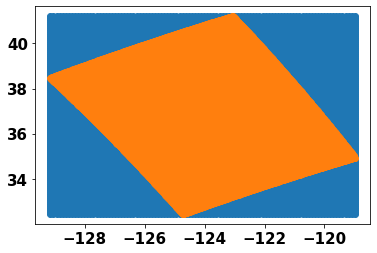

In [68]:
#each angle of rotation are the coordinates?
#np.arctan2(np.diff(var.nav_lon_grid_V[0,:]),np.diff(var.nav_lat_grid_V[0,:]))*180

#visualizing the grid
lonx=np.linspace(var.nav_lon.min(),var.nav_lon.max(),100)
latx=np.linspace(var.nav_lat.min(),var.nav_lat.max(),100)
lonx,latx=np.meshgrid(lonx,latx)

plt.scatter(lonx,latx)
plt.scatter(var.nav_lon,var.nav_lat)

# plt.figure()
# plt.contourf((var.PB[0,:,:] + var.P[0,0,:,:])/100)
# plt.colorbar()


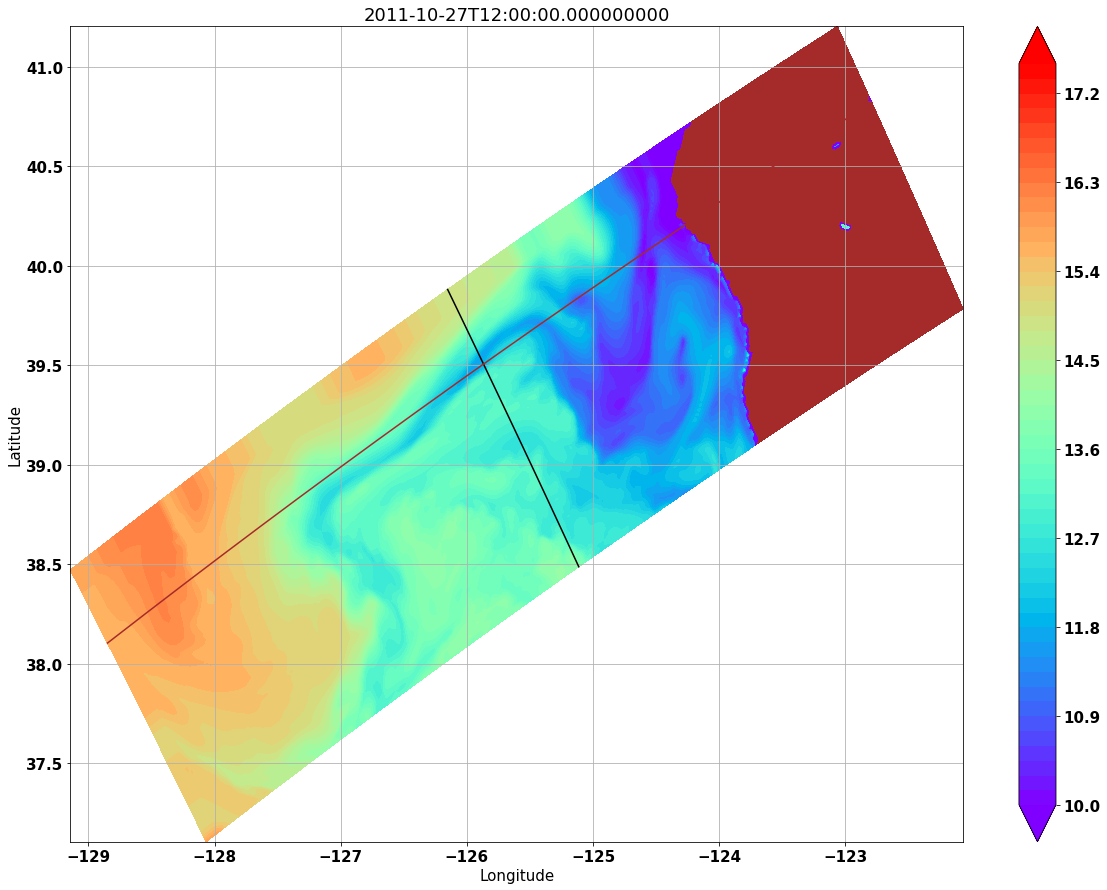

In [70]:
#[lon1,lat1] = map(unique_grid, [Dataset(listm[0])['lon_rho'][:],Dataset(listm[0])['lat_rho'][:]])
# hour=(24*4-1)
day=26


plt.rcParams['font.size']=15
plt.rcParams['font.sans-serif']='Arial'
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.weight']='bold'
var

plt.figure(figsize=(20,15))
plt.contourf(var.nav_lon[300:,:],var.nav_lat[300:,:],var.SST[day,300:,:]-273,levels=np.linspace(10,17.5,51),cmap='rainbow',extend='both');plt.colorbar()
plt.contourf(var.nav_lon[300:,:],var.nav_lat[300:,:],var.SST[0,300:,:],levels=[-np.inf,0],colors='brown')
plt.plot(var.nav_lon[300:,-150],var.nav_lat[300:,-150],'k-')
plt.plot(var.nav_lon[365,:],var.nav_lat[365,:],color='brown',linestyle='-')


plt.title(var.time_centered[day].data)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# plt.ylim(38,41)
# plt.xlim(-129,-122)
plt.grid()


In [71]:
# dec=10
# plt.figure(figsize=(20,15))

# plt.quiver(var.nav_lon_grid_U[:,:-1][::dec,::dec],var.nav_lat_grid_V[:-1,:][::dec,::dec],
#            var.U[day,0,:,:-1][::dec,::dec],var.V[day,0,:-1,:][::dec,::dec])


# plt.contourf(var.nav_lon_grid_M,var.nav_lat_grid_M,var.SST[0],levels=[-np.inf,0],colors='brown')
# plt.scatter(var.nav_lon_grid_M[:,-100],var.nav_lat_grid_M[:,-100],s=0.5)
# plt.title(var.time_centered[day].data)



# plt.grid()

In [74]:
#Pressure to Height

# R=8.31432 #N.m/mol.K
# Lb=-0.0065 #K/m
# g=9.8 #m/s2
# M= 0.0289644 #kg/mol


# Pnum=(np.array(var.PB)[None,:,:,:] + np.array(var.P))
# Pden=(np.array(var.PB)[None,0,:,:]+np.array(var.P)[:,0,:,:])
# Pratio=Pnum/Pden[:,None,:,:]


# print(Pnum.shape)
# print(Pden.shape)
# print(Pratio.shape)
# print(var.HGT.shape)
# print(var.T2.shape)

# er=(-(R*Lb)/(g*M))


# H= np.array(var.HGT)[None,None,:,:] + (np.array(var.T2)[:,None,:,:]/Lb)*(Pratio**(er)-1)

In [13]:
# plt.figure(figsize=(10,5))
# plt.contourf(var.nav_lat_grid_M[:,-100],var.PB[::-1,:,-100].mean(axis=1)/100,var.T[day,:,:,-100],
#              extend='both',cmap='inferno')

# plt.xlabel('Latitude')
# plt.ylim(750,1000)
# plt.ylabel('Pressure [hPa]')
# plt.colorbar()
# plt.gca().invert_yaxis()


# plt.figure(figsize=(10,5))
# plt.contourf(var.nav_lat_grid_M[:,-100],var.PB[::-1,:,-100].mean(axis=1)/100,var.U[day,:,:,-100],
#              levels=np.linspace(-20,20,101),extend='both',cmap='seismic')
# plt.xlabel('Latitude')
# plt.ylim(750,1000)

# plt.ylabel('Pressure [hPa]')
# plt.colorbar()
# plt.gca().invert_yaxis()


# plt.figure(figsize=(10,5))
# plt.contourf(var.nav_lat_grid_M[:,-100],var.PB[::-1,:,-100].mean(axis=1)/100,var.V[day,:,:-1,-100],
#              levels=np.linspace(-20,20,101),extend='both',cmap='seismic')
# plt.xlabel('Latitude')
# plt.ylim(750,1000)

# plt.ylabel('Pressure [hPa]')
# plt.colorbar()
# plt.gca().invert_yaxis()



# print(var.U.min())

In [75]:
import pandas as pd
a=var.time_centered[day].data
a=np.datetime64(a)

ts = pd.to_datetime(str(a)) 

ts=ts.strftime('%Y/%m/%d')
ts



'2011/10/27'

### Cross filament

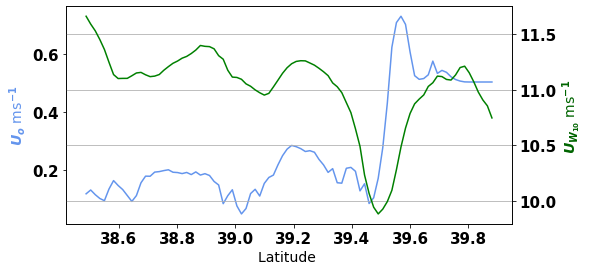

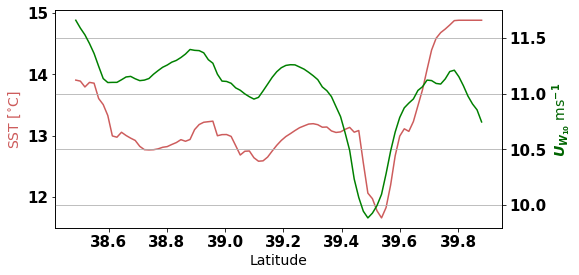

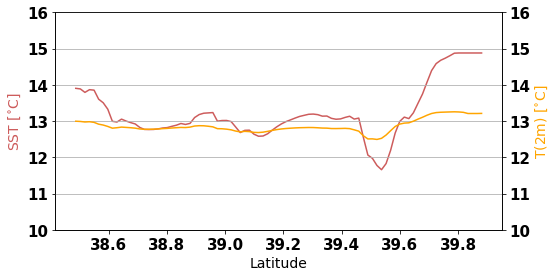

In [108]:

#Uo x Winds
fig,ax = plt.subplots(figsize=(8,4))
ax.plot(var.nav_lat[300:,-150],np.sqrt(var.UOCE[day,300:,-150]**2 +var.VOCE[day,300:,-150]**2),color="cornflowerblue")
ax.set_xlabel(r'Latitude ',fontsize=14)
ax.set_ylabel(r'$U_o$ ms$^{-1}$',color="cornflowerblue",fontsize=14)


ax2=ax.twinx()
ax2.plot(var.nav_lat[300:,-150],var.WSPD10[day,300:,-150],color='green')

ax2.set_ylabel('$U_{W_{10}}$ ms$^{-1}$ ',color="darkgreen",fontsize=14)
plt.grid()
plt.show()



fig,ax = plt.subplots(figsize=(8,4))

ax.plot(var.nav_lat[300:,-150],var.SST[day,300:,-150]-273,color="indianred")
ax.set_xlabel(r'Latitude',fontsize=14)
ax.set_ylabel(r'SST [$^{\circ}$C]',color="indianred",fontsize=14)


ax2=ax.twinx()
#ax2.plot(var.nav_lat[:,-100],np.sqrt(var.U10[day,:,-100]**2 +var.V10[day,:,-100]**2),color='darkgreen')
ax2.plot(var.nav_lat[300:,-150],var.WSPD10[day,300:,-150],color='green')
# ax2.plot(varh.nav_lat[:,-100],varh.WSPD10[day*(24):(day+1)*(24),:,-100].median(axis=0),'g--')



ax2.set_ylabel('$U_{W_{10}}$ ms$^{-1}$ ',color="darkgreen",fontsize=14)
plt.grid()

plt.show()


fig,ax = plt.subplots(figsize=(8,4))

ax.plot(var.nav_lat[300:,-150],var.SST[day,300:,-150]-273,color="indianred")
ax.set_xlabel(r'Latitude',fontsize=14)
ax.set_ylabel(r'SST [$^{\circ}$C]',color="indianred",fontsize=14)
plt.ylim(10,16)

ax2=ax.twinx()
#ax2.plot(var.nav_lat[:,-100],np.sqrt(var.U10[day,:,-100]**2 +var.V10[day,:,-100]**2),color='darkgreen')
ax2.plot(var.nav_lat[300:,-150],var.T2[day,300:,-150]-273,color='orange')
# ax2.plot(varh.nav_lat[:,-100],varh.WSPD10[day*(24):(day+1)*(24),:,-100].median(axis=0),'g--')

plt.ylim(10,16)

ax2.set_ylabel(r'T(2m) [$^{\circ}$C]',color="orange",fontsize=14)


plt.grid()

plt.show()





### Along Filament

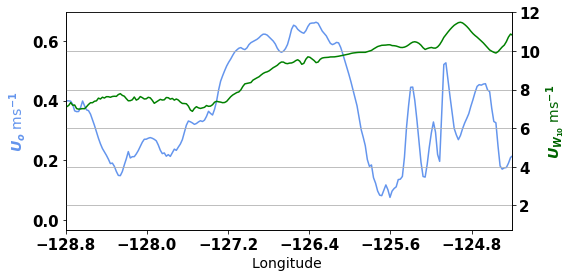

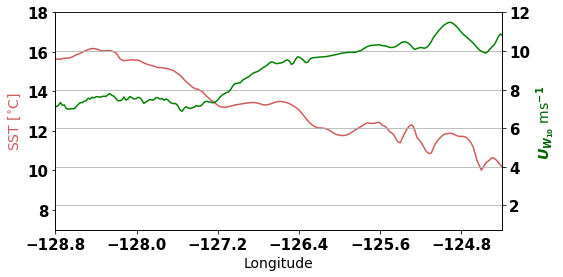

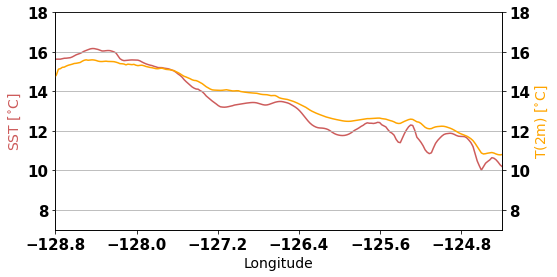

In [125]:

#Uo x Winds
fig,ax = plt.subplots(figsize=(8,4))
ax.plot(var.nav_lon[365,:],np.sqrt(var.UOCE[day,365,:]**2 +var.VOCE[day,365,:]**2),color="cornflowerblue")
ax.set_xlabel(r'Longitude ',fontsize=14)
ax.set_ylabel(r'$U_o$ ms$^{-1}$',color="cornflowerblue",fontsize=14)

ax2=ax.twinx()
ax2.plot(var.nav_lon[365,:],var.WSPD10[day,365,:],color='green')

ax2.set_ylabel('$U_{W_{10}}$ ms$^{-1}$ ',color="darkgreen",fontsize=14)
plt.xticks(np.arange(-128.8,-124.4,0.8))
plt.xlim(-128.8,-124.4)
plt.grid()
plt.show()


fig,ax = plt.subplots(figsize=(8,4))

ax.plot(var.nav_lon[365,:],var.SST[day,365,:]-273,color="indianred")
ax.set_xlabel(r'Longitude',fontsize=14)
ax.set_ylabel(r'SST [$^{\circ}$C]',color="indianred",fontsize=14)
plt.ylim(7,18)



ax2=ax.twinx()
#ax2.plot(var.nav_lat[:,-100],np.sqrt(var.U10[day,:,-100]**2 +var.V10[day,:,-100]**2),color='darkgreen')
ax2.plot(var.nav_lon[365,:],var.WSPD10[day,365,:],color='green')
# ax2.plot(varh.nav_lat[:,-100],varh.WSPD10[day*(24):(day+1)*(24),:,-100].median(axis=0),'g--')

ax2.set_ylabel('$U_{W_{10}}$ ms$^{-1}$ ',color="darkgreen",fontsize=14)


plt.xticks(np.arange(-128.8,-124.4,0.8))
plt.xlim(-128.8,-124.4)

plt.grid()
plt.show()


fig,ax = plt.subplots(figsize=(8,4))


ax.plot(var.nav_lon[365,:],var.SST[day,365,:]-273,color="indianred")
plt.ylim(7,18)
ax.set_xlabel(r'Longitude',fontsize=14)
ax.set_ylabel(r'SST [$^{\circ}$C]',color="indianred",fontsize=14)


ax2=ax.twinx()
#ax2.plot(var.nav_lat[:,-100],np.sqrt(var.U10[day,:,-100]**2 +var.V10[day,:,-100]**2),color='darkgreen')
ax2.plot(var.nav_lon[365,:],var.T2[day,365,:]-273,color='orange')
# ax2.plot(varh.nav_lat[:,-100],varh.WSPD10[day*(24):(day+1)*(24),:,-100].median(axis=0),'g--')
plt.ylim(7,18)



ax2.set_ylabel(r'T(2m) [$^{\circ}$C]',color="orange",fontsize=14)
plt.xticks(np.arange(-128.8,-124.4,0.8))
plt.xlim(-128.8,-124.4)

plt.grid()

plt.show()



